In [248]:
import copy
import joblib
import os
import glob
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, f1_score
from sklearn.manifold import TSNE
from torch.nn import BCELoss, BCEWithLogitsLoss, Sequential, LeakyReLU, Linear
from torch.utils.data import DataLoader, TensorDataset
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.model_selection import GridSearchCV
from scipy.spatial.distance import cdist
from sklearn.metrics.cluster import homogeneity_score, v_measure_score
from matplotlib import rc
# from torch_explain.nn import ConceptEmbeddings, context, semantics
# import pytorch_lightning as pl
# from pytorch_lightning import seed_everything
# from torch_explain.nn.vector_logic import NeSyLayer, to_boolean

# parameters for data, model, and training
cv = 3
emb_sizes = [2, 10, 50]
sns.set(font_scale=1.3)
sns.set_style('whitegrid')
figsize = [9, 4]
# palette = [sns.color_palette("Paired")[i] for i in [5, 3]]
# palette = [sns.color_palette("Paired")[i] for i in [5, 2, 3, 6, 7, 1, 0]]
# palette = [sns.color_palette("Paired")[i] for i in [5, 2, 6, 7]]
# palette = [sns.color_palette("Paired")[i] for i in [1, 0, 7, 6, 3, 2, 5]]
palette = [sns.color_palette("Paired")[i] for i in [7, 6, 3, 2, 5]]
step = 500
LATEX_SYMBOL = ""  # Change to "$" if working out of server
rc('text', usetex=(LATEX_SYMBOL == "$"))
plt.style.use('seaborn-whitegrid')

experiments = {
    'XOR': './results/xor_activations/test_embedding_acts/',
    'Trigonometry': './results/trig_activations_expr/test_embedding_acts/',
    'Dot': './results/toy_activations_expr/test_embedding_acts/',
#     'CUB': './results/cub_activations_expr/test_embedding_acts/',
    'CUB*': './results/cub_activations_expr_sub/test_embedding_acts/',
#     'CelebA': '/local/scratch/me466/results/celeba_activations/test_embedding_acts/',
}
methods = {
#     'ConceptBottleneckModelNoConceptSupervision': 'VanillaModel',
#     'ConceptBottleneckModelNoConceptSupervision_ExtraCapacity': 'VanillaModel+',
    'ConceptBottleneckModelBool': 'Bool',
    'ConceptBottleneckModelFuzzy': 'Fuzzy', 
    'ConceptBottleneckModelFuzzyExtraCapacity': 'Fuzzy+',
    'MaskedSplitEmbModelBounded': 'Masked Bounded Embedding',
    'SplitEmbModelSharedProb': 'Shared Split Embedding',
}

In [249]:
def embedding_homogeneity(c_vec: np.array, c_test: np.array, y_test: np.array, step: int) -> [float, float]:
    """
    Computes the alignment between learnt concepts and labels.

    :param c_vec: predicted concept representations (can be concept embeddings)
    :param c_test: concept ground truth labels
    :param y_test: task ground truth labels
    :param step: integration step
    :return: concept alignment AUC, task alignment AUC
    """
    # compute the maximum value for the AUC
    n_clusters = np.arange(2, c_vec.shape[0], step)
    max_auc = np.trapz(np.ones(len(n_clusters)))

    # for each concept:
    #   1. find clusters
    #   2. compare cluster assignments with ground truth concept/task labels
    concept_auc, task_auc = [], []
    for concept_id in range(c_test.shape[1]):
        concept_homogeneity, task_homogeneity = [], []
        for nc in n_clusters:
            # train clustering algorithm
            kmedoids = KMedoids(n_clusters=nc, random_state=0)
            if c_vec.shape[1] != c_test.shape[1]:
                c_cluster_labels = kmedoids.fit_predict(c_vec)
            elif c_vec.shape[1] == c_test.shape[1] and len(c_vec.shape) == 2:
                c_cluster_labels = kmedoids.fit_predict(c_vec[:, concept_id].reshape(-1, 1))
            else:
                c_cluster_labels = kmedoids.fit_predict(c_vec[:, concept_id])

            # compute alignment with ground truth labels
            concept_homogeneity.append(homogeneity_score(c_test[:, concept_id], c_cluster_labels))
            task_homogeneity.append(homogeneity_score(y_test, c_cluster_labels))

        # compute the area under the curve
        concept_auc.append(np.trapz(np.array(concept_homogeneity)) / max_auc)
        task_auc.append(np.trapz(np.array(task_homogeneity)) / max_auc)

    # return the average alignment across all concepts
    concept_auc = np.mean(concept_auc)
    task_auc = np.mean(task_auc)
    return concept_auc, task_auc

In [250]:
auc_scores = pd.DataFrame()
columns = ['experiment', 'concept AUC (%)', 'task AUC (%)', 'method_id', 'method', 'fold']
for experiment_name, result_dir in experiments.items():
    c_test = np.load(os.path.join(result_dir, 'c_test.npy'))
    y_test = np.load(os.path.join(result_dir, 'y_test.npy'))
    resnet = ''
    cv = 5
    epochs = 3100
    step = 500
    if experiment_name == 'CUB':
        resnet = '_resnet34'
        epochs = 250
        cv = 3
    elif experiment_name == 'CUB*':
        resnet = '_subsample_0.05_resnet34'
        epochs = 250
        cv = 3
    elif experiment_name == 'CelebA':
        resnet = '_resnet34'
        epochs = 200
        cv = 3
    elif experiment_name == 'XOR':
        epochs = 1035
        step = 50
    
    for method_id, (method, method_name) in enumerate(methods.items()):
        for fold in range(cv):
#             fold = 1
            print(experiment_name, result_dir, method, fold+1)
            
#             print(os.path.join(result_dir, f'{method}{resnet}_fold_{fold+1}', f'test_embedding_semantics_on_epoch_{epochs}.npy'))
            c_pred = np.load(os.path.join(result_dir, f'{method}{resnet}_fold_{fold+1}', f'test_embedding_semantics_on_epoch_{epochs}.npy'))
            c_vec = np.load(os.path.join(result_dir, f'{method}{resnet}_fold_{fold+1}', f'test_embedding_vectors_on_epoch_{epochs}.npy'))
            y_pred = np.load(os.path.join(result_dir, f'{method}{resnet}_fold_{fold+1}', f'test_model_output_on_epoch_{epochs}.npy'))
            
            if experiment_name == 'CUB*':
                c_test = np.load(os.path.join(result_dir, 'c_test.npy'))
                selected_concepts = np.load(f"./results/cub_activations_expr_sub/selected_concepts_sampling_0.05_fold_{fold}.npy")
                c_test = c_test[:, selected_concepts]
            
            if method_name == 'Fuzzy+':
                c_vec = c_vec[:, c_test.shape[1]:]
            elif method_name in ['Shared Split Embedding', 'Masked Bounded Embedding']:
                c_vec = c_vec.reshape(c_test.shape[0], c_test.shape[1], -1)[:, :, :-1]
            
            concept_auc, task_auc = auc_truth_table_score(c_vec, c_test, y_test, step)
            auc_scores = auc_scores.append(pd.DataFrame([[experiment_name, concept_auc*100, task_auc*100, method_id, method_name, fold]], columns=columns))
#             break
#         break
auc_scores.reset_index(inplace=True)
#     break

XOR ./results/xor_activations/test_embedding_acts/ ConceptBottleneckModelBool 1
XOR

C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 187 is empty! self.labels_[self.medoid_indices_[187]] may not be labeled with its corresponding cluster (187).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 188 is empty! self.labels_[self.medoid_indices_[188]] may not be labeled with its corresponding cluster (188).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 194 is empty! self.labels_[self.medoid_indices_[194]] may not be labeled with its corresponding cluster (194).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 195 is empty! self.labels_[self.medoid_indices_[195]] may not be labeled with its corresponding cluster (195).
  warnings.warn(
C:\Users\pie

 ./results/xor_activations/test_embedding_acts/ ConceptBottleneckModelBool 2
XOR ./results/xor_activations/test_embedding_acts/ ConceptBottleneckModelBool 3


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 186 is empty! self.labels_[self.medoid_indices_[186]] may not be labeled with its corresponding cluster (186).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 187 is empty! self.labels_[self.medoid_indices_[187]] may not be labeled with its corresponding cluster (187).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 188 is empty! self.labels_[self.medoid_indices_[188]] may not be labeled with its corresponding cluster (188).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 190 is empty! self.labels_[self.medoid_indices_[190]] may not be labeled with its corresponding cluster (190).
  warnings.warn(
C:\Users\pie

C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch1

XOR ./results/xor_activations/test_embedding_acts/ ConceptBottleneckModelBool 4
XOR ./results/xor_activations/test_embedding_acts/ ConceptBottleneckModelBool 5


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch1

XOR ./results/xor_activations/test_embedding_acts/ ConceptBottleneckModelFuzzy 1
XOR ./results/xor_activations/test_embedding_acts/ ConceptBottleneckModelFuzzy 2


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 189 is empty! self.labels_[self.medoid_indices_[189]] may not be labeled with its corresponding cluster (189).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 193 is empty! self.labels_[self.medoid_indices_[193]] may not be labeled with its corresponding cluster (193).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 201 is empty! self.labels_[self.medoid_indices_[201]] may not be labeled with its corresponding cluster (201).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  warnings.warn(
C:\Users\pietr\ana

C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch1

XOR ./results/xor_activations/test_embedding_acts/ ConceptBottleneckModelFuzzy 3
XOR ./results/xor_activations/test_embedding_acts/ ConceptBottleneckModelFuzzy 4


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch1

XOR ./results/xor_activations/test_embedding_acts/ ConceptBottleneckModelFuzzy 5
XOR ./results/xor_activations/test_embedding_acts/ ConceptBottleneckModelFuzzyExtraCapacity 1


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 191 is empty! self.labels_[self.medoid_indices_[191]] may not be labeled with its corresponding cluster (191).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 192 is empty! self.labels_[self.medoid_indices_[192]] may not be labeled with its corresponding cluster (192).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 193 is empty! self.labels_[self.medoid_indices_[193]] may not be labeled with its corresponding cluster (193).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 195 is empty! self.labels_[self.medoid_indices_[195]] may not be labeled with its corresponding cluster (195).
  warnings.warn(
C:\Users\pie

XOR ./results/xor_activations/test_embedding_acts/ ConceptBottleneckModelFuzzyExtraCapacity 2
XOR ./results/xor_activations/test_embedding_acts/ ConceptBottleneckModelFuzzyExtraCapacity 3
XOR ./results/xor_activations/test_embedding_acts/ ConceptBottleneckModelFuzzyExtraCapacity 4
XOR ./results/xor_activations/test_embedding_acts/ ConceptBottleneckModelFuzzyExtraCapacity 5
XOR ./results/xor_activations/test_embedding_acts/ MaskedSplitEmbModelBounded 1


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch1

C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 36 is empty! self.labels_[self.medoid_indices_[36]] may not be labeled with its corresponding cluster (36).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 37 is empty! self.labels_[self.medoid_indices_[37]] may not be labeled with its corresponding cluster (37).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 38 is empty! self.labels_[self.medoid_indices_[38]] may not be labeled with its corresponding cluster (38).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 39 is empty! self.labels_[self.medoid_indices_[39]] may not be labeled with its corresponding cluster (39).
  warnings.warn(
C:\Users\pietr\anaconda3

XOR ./results/xor_activations/test_embedding_acts/ MaskedSplitEmbModelBounded 2


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 50 is empty! self.labels_[self.medoid_indices_[50]] may not be labeled with its corresponding cluster (50).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 51 is empty! self.labels_[self.medoid_indices_[51]] may not be labeled with its corresponding cluster (51).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 53 is empty! self.labels_[self.medoid_indices_[53]] may not be labeled with its corresponding cluster (53).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 54 is empty! self.labels_[self.medoid_indices_[54]] may not be labeled with its corresponding cluster (54).
  warnings.warn(
C:\Users\pietr\anaconda3

C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 22 is empty! self.labels_[self.medoid_indices_[22]] may not be labeled with its corresponding cluster (22).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 25 is empty! self.labels_[self.medoid_indices_[25]] may not be labeled with its corresponding cluster (25).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 28 is empty! self.labels_[self.medoid_indices_[28]] may not be labeled with its corresponding cluster (28).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 30 is empty! self.labels_[self.medoid_indices_[30]] may not be labeled with its corresponding cluster (30).
  warnings.warn(
C:\Users\pietr\anaconda3

XOR ./results/xor_activations/test_embedding_acts/ MaskedSplitEmbModelBounded 3


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 8 is empty! self.labels_[self.medoid_indices_[8]] may not be labeled with its corresponding cluster (8).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 9 is empty! self.labels_[self.medoid_indices_[9]] may not be labeled with its corresponding cluster (9).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 11 is empty! self.labels_[self.medoid_indices_[11]] may not be labeled with its corresponding cluster (11).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\tor

XOR ./results/xor_activations/test_embedding_acts/ MaskedSplitEmbModelBounded 4


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 39 is empty! self.labels_[self.medoid_indices_[39]] may not be labeled with its corresponding cluster (39).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 41 is empty! self.labels_[self.medoid_indices_[41]] may not be labeled with its corresponding cluster (41).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 42 is empty! self.labels_[self.medoid_indices_[42]] may not be labeled with its corresponding cluster (42).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 43 is empty! self.labels_[self.medoid_indices_[43]] may not be labeled with its corresponding cluster (43).
  warnings.warn(
C:\Users\pietr\anaconda3

C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 95 is empty! self.labels_[self.medoid_indices_[95]] may not be labeled with its corresponding cluster (95).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 96 is empty! self.labels_[self.medoid_indices_[96]] may not be labeled with its corresponding cluster (96).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 97 is empty! self.labels_[self.medoid_indices_[97]] may not be labeled with its corresponding cluster (97).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 100 is empty! self.labels_[self.medoid_indices_[100]] may not be labeled with its corresponding cluster (100).
  warnings.warn(
C:\Users\pietr\anacon

XOR ./results/xor_activations/test_embedding_acts/ MaskedSplitEmbModelBounded 5


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 31 is empty! self.labels_[self.medoid_indices_[31]] may not be labeled with its corresponding cluster (31).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 32 is empty! self.labels_[self.medoid_indices_[32]] may not be labeled with its corresponding cluster (32).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 36 is empty! self.labels_[self.medoid_indices_[36]] may not be labeled with its corresponding cluster (36).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 37 is empty! self.labels_[self.medoid_indices_[37]] may not be labeled with its corresponding cluster (37).
  warnings.warn(
C:\Users\pietr\anaconda3

XOR ./results/xor_activations/test_embedding_acts/ SplitEmbModelSharedProb 1
XOR ./results/xor_activations/test_embedding_acts/ SplitEmbModelSharedProb 2
XOR ./results/xor_activations/test_embedding_acts/ SplitEmbModelSharedProb 3
XOR ./results/xor_activations/test_embedding_acts/ SplitEmbModelSharedProb 4
XOR ./results/xor_activations/test_embedding_acts/ SplitEmbModelSharedProb 5
Trigonometry ./results/trig_activations_expr/test_embedding_acts/ ConceptBottleneckModelBool 1
Trigonometry ./results/trig_activations_expr/test_embedding_acts/ ConceptBottleneckModelBool 2


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 9 is empty! self.labels_[self.medoid_indices_[9]] may not be labeled with its corresponding cluster (9).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch1

C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 251 is empty! self.labels_[self.medoid_indices_[251]] may not be labeled with its corresponding cluster (251).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 252 is empty! self.labels_[self.medoid_indices_[252]] may not be labeled with its corresponding cluster (252).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 253 is empty! self.labels_[self.medoid_indices_[253]] may not be labeled with its corresponding cluster (253).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 256 is empty! self.labels_[self.medoid_indices_[256]] may not be labeled with its corresponding cluster (256).
  warnings.warn(
C:\Users\pie

Trigonometry ./results/trig_activations_expr/test_embedding_acts/ ConceptBottleneckModelBool 3
Trigonometry ./results/trig_activations_expr/test_embedding_acts/ ConceptBottleneckModelBool 4


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch1

Trigonometry ./results/trig_activations_expr/test_embedding_acts/ ConceptBottleneckModelBool 5
Trigonometry ./results/trig_activations_expr/test_embedding_acts/ ConceptBottleneckModelFuzzy 1


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 272 is empty! self.labels_[self.medoid_indices_[272]] may not be labeled with its corresponding cluster (272).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 273 is empty! self.labels_[self.medoid_indices_[273]] may not be labeled with its corresponding cluster (273).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 274 is empty! self.labels_[self.medoid_indices_[274]] may not be labeled with its corresponding cluster (274).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 275 is empty! self.labels_[self.medoid_indices_[275]] may not be labeled with its corresponding cluster (275).
  warnings.warn(
C:\Users\pie

Trigonometry ./results/trig_activations_expr/test_embedding_acts/ ConceptBottleneckModelFuzzy 2
Trigonometry ./results/trig_activations_expr/test_embedding_acts/ ConceptBottleneckModelFuzzy 3


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 9 is empty! self.labels_[self.medoid_indices_[9]] may not be labeled with its corresponding cluster (9).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 12 is empty! self.labels_[self.medoid_indices_[12]] may not be labeled with its corresponding cluster (12).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\tor

C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 9 is empty! self.labels_[self.medoid_indices_[9]] may not be labeled with its corresponding cluster (9).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 10 is empty! self.labels_[self.medoid_indices_[10]] may not be labeled with its corresponding cluster (10).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 11 is empty! self.labels_[self.medoid_indices_[11]] may not be labeled with its corresponding cluster (11).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\

Trigonometry ./results/trig_activations_expr/test_embedding_acts/ ConceptBottleneckModelFuzzy 4
Trigonometry ./results/trig_activations_expr/test_embedding_acts/ ConceptBottleneckModelFuzzy 5


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 317 is empty! self.labels_[self.medoid_indices_[317]] may not be labeled with its corresponding cluster (317).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 330 is empty! self.labels_[self.medoid_indices_[330]] may not be labeled with its corresponding cluster (330).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 331 is empty! self.labels_[self.medoid_indices_[331]] may not be labeled with its corresponding cluster (331).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 488 is empty! self.labels_[self.medoid_indices_[488]] may not be labeled with its corresponding cluster (488).
  warnings.warn(
C:\Users\pie

Trigonometry ./results/trig_activations_expr/test_embedding_acts/ ConceptBottleneckModelFuzzyExtraCapacity 1
Trigonometry ./results/trig_activations_expr/test_embedding_acts/ ConceptBottleneckModelFuzzyExtraCapacity 2
Trigonometry ./results/trig_activations_expr/test_embedding_acts/ ConceptBottleneckModelFuzzyExtraCapacity 3
Trigonometry ./results/trig_activations_expr/test_embedding_acts/ ConceptBottleneckModelFuzzyExtraCapacity 4
Trigonometry ./results/trig_activations_expr/test_embedding_acts/ ConceptBottleneckModelFuzzyExtraCapacity 5
Trigonometry ./results/trig_activations_expr/test_embedding_acts/ MaskedSplitEmbModelBounded 1


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 6 is empty! self.labels_[self.medoid_indices_[6]] may not be labeled with its corresponding cluster (6).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 8 is empty! self.labels_[self.medoid_indices_[8]] may not be labeled with its corresponding cluster (8).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch1

Trigonometry ./results/trig_activations_expr/test_embedding_acts/ MaskedSplitEmbModelBounded 2


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch1

Trigonometry ./results/trig_activations_expr/test_embedding_acts/ MaskedSplitEmbModelBounded 3


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 18 is empty! self.labels_[self.medoid_indices_[18]] may not be labeled with its corresponding cluster (18).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 20 is empty! self.labels_[self.medoid_indices_[20]] may not be labeled with its corresponding cluster (20).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 21 is empty! self.labels_[self.medoid_indices_[21]] may not be labeled with its corresponding cluster (21).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 22 is empty! self.labels_[self.medoid_indices_[22]] may not be labeled with its corresponding cluster (22).
  warnings.warn(
C:\Users\pietr\anaconda3

Trigonometry ./results/trig_activations_expr/test_embedding_acts/ MaskedSplitEmbModelBounded 4


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 10 is empty! self.labels_[self.medoid_indices_[10]] may not be labeled with its corresponding cluster (10).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 11 is empty! self.labels_[self.medoid_indices_[11]] may not be labeled with its corresponding cluster (11).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 14 is empty! self.labels_[self.medoid_indices_[14]] may not be labeled with its corresponding cluster (14).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 15 is empty! self.labels_[self.medoid_indices_[15]] may not be labeled with its corresponding cluster (15).
  warnings.warn(
C:\Users\pietr\anaconda3

Trigonometry ./results/trig_activations_expr/test_embedding_acts/ MaskedSplitEmbModelBounded 5


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 45 is empty! self.labels_[self.medoid_indices_[45]] may not be labeled with its corresponding cluster (45).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 48 is empty! self.labels_[self.medoid_indices_[48]] may not be labeled with its corresponding cluster (48).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 49 is empty! self.labels_[self.medoid_indices_[49]] may not be labeled with its corresponding cluster (49).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 50 is empty! self.labels_[self.medoid_indices_[50]] may not be labeled with its corresponding cluster (50).
  warnings.warn(
C:\Users\pietr\anaconda3

Trigonometry ./results/trig_activations_expr/test_embedding_acts/ SplitEmbModelSharedProb 1
Trigonometry ./results/trig_activations_expr/test_embedding_acts/ SplitEmbModelSharedProb 2
Trigonometry ./results/trig_activations_expr/test_embedding_acts/ SplitEmbModelSharedProb 3
Trigonometry ./results/trig_activations_expr/test_embedding_acts/ SplitEmbModelSharedProb 4
Trigonometry ./results/trig_activations_expr/test_embedding_acts/ SplitEmbModelSharedProb 5
Dot ./results/toy_activations_expr/test_embedding_acts/ ConceptBottleneckModelBool 1


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 6 is empty! self.labels_[self.medoid_indices_[6]] may not be labeled with its corresponding cluster (6).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch1

Dot ./results/toy_activations_expr/test_embedding_acts/ ConceptBottleneckModelBool 2
Dot ./results/toy_activations_expr/test_embedding_acts/ ConceptBottleneckModelBool 3


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 9 is empty! self.labels_[self.medoid_indices_[9]] may not be labeled with its corresponding cluster (9).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 11 is empty! self.labels_[self.medoid_indices_[11]] may not be labeled with its corresponding cluster (11).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 13 is empty! self.labels_[self.medoid_indices_[13]] may not be labeled with its corresponding cluster (13).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 14 is empty! self.labels_[self.medoid_indices_[14]] may not be labeled with its corresponding cluster (14).
  warnings.warn(
C:\Users\pietr\anaconda3\en

Dot ./results/toy_activations_expr/test_embedding_acts/ ConceptBottleneckModelBool 4
Dot ./results/toy_activations_expr/test_embedding_acts/ ConceptBottleneckModelBool 5


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 6 is empty! self.labels_[self.medoid_indices_[6]] may not be labeled with its corresponding cluster (6).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 9 is empty! self.labels_[self.medoid_indices_[9]] may not be labeled with its corresponding cluster (9).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 11 is empty! self.labels_[self.medoid_indices_[11]] may not be labeled with its corresponding cluster (11).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\tor

Dot ./results/toy_activations_expr/test_embedding_acts/ ConceptBottleneckModelFuzzy 1
Dot ./results/toy_activations_expr/test_embedding_acts/ ConceptBottleneckModelFuzzy 2
Dot ./results/toy_activations_expr/test_embedding_acts/ ConceptBottleneckModelFuzzy 3


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 44 is empty! self.labels_[self.medoid_indices_[44]] may not be labeled with its corresponding cluster (44).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 57 is empty! self.labels_[self.medoid_indices_[57]] may not be labeled with its corresponding cluster (57).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 183 is empty! self.labels_[self.medoid_indices_[183]] may not be labeled with its corresponding cluster (183).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 186 is empty! self.labels_[self.medoid_indices_[186]] may not be labeled with its corresponding cluster (186).
  warnings.warn(
C:\Users\pietr\ana

Dot ./results/toy_activations_expr/test_embedding_acts/ ConceptBottleneckModelFuzzy 4
Dot ./results/toy_activations_expr/test_embedding_acts/ ConceptBottleneckModelFuzzy 5
Dot ./results/toy_activations_expr/test_embedding_acts/ ConceptBottleneckModelFuzzyExtraCapacity 1


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 391 is empty! self.labels_[self.medoid_indices_[391]] may not be labeled with its corresponding cluster (391).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 392 is empty! self.labels_[self.medoid_indices_[392]] may not be labeled with its corresponding cluster (392).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 393 is empty! self.labels_[self.medoid_indices_[393]] may not be labeled with its corresponding cluster (393).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 394 is empty! self.labels_[self.medoid_indices_[394]] may not be labeled with its corresponding cluster (394).
  warnings.warn(
C:\Users\pie

Dot ./results/toy_activations_expr/test_embedding_acts/ ConceptBottleneckModelFuzzyExtraCapacity 2
Dot ./results/toy_activations_expr/test_embedding_acts/ ConceptBottleneckModelFuzzyExtraCapacity 3
Dot ./results/toy_activations_expr/test_embedding_acts/ ConceptBottleneckModelFuzzyExtraCapacity 4
Dot ./results/toy_activations_expr/test_embedding_acts/ ConceptBottleneckModelFuzzyExtraCapacity 5
Dot ./results/toy_activations_expr/test_embedding_acts/ MaskedSplitEmbModelBounded 1
Dot ./results/toy_activations_expr/test_embedding_acts/ MaskedSplitEmbModelBounded 2


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 9 is empty! self.labels_[self.medoid_indices_[9]] may not be labeled with its corresponding cluster (9).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch1

C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 1 is empty! self.labels_[self.medoid_indices_[1]] may not be labeled with its corresponding cluster (1).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 6 is empty! self.labels_[self.medoid_indices_[6]] may not be labeled with its corresponding cluster (6).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch1

Dot ./results/toy_activations_expr/test_embedding_acts/ MaskedSplitEmbModelBounded 3
Dot ./results/toy_activations_expr/test_embedding_acts/ MaskedSplitEmbModelBounded 4


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 2 is empty! self.labels_[self.medoid_indices_[2]] may not be labeled with its corresponding cluster (2).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 3 is empty! self.labels_[self.medoid_indices_[3]] may not be labeled with its corresponding cluster (3).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 6 is empty! self.labels_[self.medoid_indices_[6]] may not be labeled with its corresponding cluster (6).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 9 is empty! self.labels_[self.medoid_indices_[9]] may not be labeled with its corresponding cluster (9).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch1

Dot ./results/toy_activations_expr/test_embedding_acts/ MaskedSplitEmbModelBounded 5
Dot ./results/toy_activations_expr/test_embedding_acts/ SplitEmbModelSharedProb 1


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 166 is empty! self.labels_[self.medoid_indices_[166]] may not be labeled with its corresponding cluster (166).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 172 is empty! self.labels_[self.medoid_indices_[172]] may not be labeled with its corresponding cluster (172).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 178 is empty! self.labels_[self.medoid_indices_[178]] may not be labeled with its corresponding cluster (178).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 182 is empty! self.labels_[self.medoid_indices_[182]] may not be labeled with its corresponding cluster (182).
  warnings.warn(
C:\Users\pie

Dot ./results/toy_activations_expr/test_embedding_acts/ SplitEmbModelSharedProb 2
Dot ./results/toy_activations_expr/test_embedding_acts/ SplitEmbModelSharedProb 3
Dot ./results/toy_activations_expr/test_embedding_acts/ SplitEmbModelSharedProb 4
Dot ./results/toy_activations_expr/test_embedding_acts/ SplitEmbModelSharedProb 5
CUB* ./results/cub_activations_expr_sub/test_embedding_acts/ ConceptBottleneckModelBool 1


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 639 is empty! self.labels_[self.medoid_indices_[639]] may not be labeled with its corresponding cluster (639).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 428 is empty! self.labels_[self.medoid_indices_[428]] may not be labeled with its corresponding cluster (428).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 433 is empty! self.labels_[self.medoid_indices_[433]] may not be labeled with its corresponding cluster (433).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 448 is empty! self.labels_[self.medoid_indices_[448]] may not be labeled with its corresponding cluster (448).
  warnings.warn(
C:\Users\pie

CUB* ./results/cub_activations_expr_sub/test_embedding_acts/ ConceptBottleneckModelBool 2


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 478 is empty! self.labels_[self.medoid_indices_[478]] may not be labeled with its corresponding cluster (478).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 661 is empty! self.labels_[self.medoid_indices_[661]] may not be labeled with its corresponding cluster (661).
  warnings.warn(


CUB* ./results/cub_activations_expr_sub/test_embedding_acts/ ConceptBottleneckModelBool 3


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 817 is empty! self.labels_[self.medoid_indices_[817]] may not be labeled with its corresponding cluster (817).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 838 is empty! self.labels_[self.medoid_indices_[838]] may not be labeled with its corresponding cluster (838).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 854 is empty! self.labels_[self.medoid_indices_[854]] may not be labeled with its corresponding cluster (854).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 893 is empty! self.labels_[self.medoid_indices_[893]] may not be labeled with its corresponding cluster (893).
  warnings.warn(
C:\Users\pie

CUB* ./results/cub_activations_expr_sub/test_embedding_acts/ ConceptBottleneckModelFuzzy 1


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 468 is empty! self.labels_[self.medoid_indices_[468]] may not be labeled with its corresponding cluster (468).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 478 is empty! self.labels_[self.medoid_indices_[478]] may not be labeled with its corresponding cluster (478).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 597 is empty! self.labels_[self.medoid_indices_[597]] may not be labeled with its corresponding cluster (597).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 621 is empty! self.labels_[self.medoid_indices_[621]] may not be labeled with its corresponding cluster (621).
  warnings.warn(
C:\Users\pie

CUB* ./results/cub_activations_expr_sub/test_embedding_acts/ ConceptBottleneckModelFuzzy 2


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 474 is empty! self.labels_[self.medoid_indices_[474]] may not be labeled with its corresponding cluster (474).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 475 is empty! self.labels_[self.medoid_indices_[475]] may not be labeled with its corresponding cluster (475).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 476 is empty! self.labels_[self.medoid_indices_[476]] may not be labeled with its corresponding cluster (476).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 477 is empty! self.labels_[self.medoid_indices_[477]] may not be labeled with its corresponding cluster (477).
  warnings.warn(
C:\Users\pie

CUB* ./results/cub_activations_expr_sub/test_embedding_acts/ ConceptBottleneckModelFuzzy 3


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 303 is empty! self.labels_[self.medoid_indices_[303]] may not be labeled with its corresponding cluster (303).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 284 is empty! self.labels_[self.medoid_indices_[284]] may not be labeled with its corresponding cluster (284).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 587 is empty! self.labels_[self.medoid_indices_[587]] may not be labeled with its corresponding cluster (587).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 601 is empty! self.labels_[self.medoid_indices_[601]] may not be labeled with its corresponding cluster (601).
  warnings.warn(
C:\Users\pie

C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 433 is empty! self.labels_[self.medoid_indices_[433]] may not be labeled with its corresponding cluster (433).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 480 is empty! self.labels_[self.medoid_indices_[480]] may not be labeled with its corresponding cluster (480).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 384 is empty! self.labels_[self.medoid_indices_[384]] may not be labeled with its corresponding cluster (384).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 432 is empty! self.labels_[self.medoid_indices_[432]] may not be labeled with its corresponding cluster (432).
  warnings.warn(
C:\Users\pie

C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 320 is empty! self.labels_[self.medoid_indices_[320]] may not be labeled with its corresponding cluster (320).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 358 is empty! self.labels_[self.medoid_indices_[358]] may not be labeled with its corresponding cluster (358).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 374 is empty! self.labels_[self.medoid_indices_[374]] may not be labeled with its corresponding cluster (374).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 393 is empty! self.labels_[self.medoid_indices_[393]] may not be labeled with its corresponding cluster (393).
  warnings.warn(
C:\Users\pie

CUB* ./results/cub_activations_expr_sub/test_embedding_acts/ ConceptBottleneckModelFuzzyExtraCapacity 1
CUB* ./results/cub_activations_expr_sub/test_embedding_acts/ ConceptBottleneckModelFuzzyExtraCapacity 2
CUB* ./results/cub_activations_expr_sub/test_embedding_acts/ ConceptBottleneckModelFuzzyExtraCapacity 3
CUB* ./results/cub_activations_expr_sub/test_embedding_acts/ MaskedSplitEmbModelBounded 1


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 438 is empty! self.labels_[self.medoid_indices_[438]] may not be labeled with its corresponding cluster (438).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 165 is empty! self.labels_[self.medoid_indices_[165]] may not be labeled with its corresponding cluster (165).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 155 is empty! self.labels_[self.medoid_indices_[155]] may not be labeled with its corresponding cluster (155).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 233 is empty! self.labels_[self.medoid_indices_[233]] may not be labeled with its corresponding cluster (233).
  warnings.warn(
C:\Users\pie

CUB* ./results/cub_activations_expr_sub/test_embedding_acts/ MaskedSplitEmbModelBounded 2


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 221 is empty! self.labels_[self.medoid_indices_[221]] may not be labeled with its corresponding cluster (221).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 261 is empty! self.labels_[self.medoid_indices_[261]] may not be labeled with its corresponding cluster (261).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 221 is empty! self.labels_[self.medoid_indices_[221]] may not be labeled with its corresponding cluster (221).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 261 is empty! self.labels_[self.medoid_indices_[261]] may not be labeled with its corresponding cluster (261).
  warnings.warn(
C:\Users\pie

C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 85 is empty! self.labels_[self.medoid_indices_[85]] may not be labeled with its corresponding cluster (85).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 93 is empty! self.labels_[self.medoid_indices_[93]] may not be labeled with its corresponding cluster (93).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 134 is empty! self.labels_[self.medoid_indices_[134]] may not be labeled with its corresponding cluster (134).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 151 is empty! self.labels_[self.medoid_indices_[151]] may not be labeled with its corresponding cluster (151).
  warnings.warn(
C:\Users\pietr\ana

CUB* ./results/cub_activations_expr_sub/test_embedding_acts/ MaskedSplitEmbModelBounded 3


C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 331 is empty! self.labels_[self.medoid_indices_[331]] may not be labeled with its corresponding cluster (331).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 465 is empty! self.labels_[self.medoid_indices_[465]] may not be labeled with its corresponding cluster (465).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 480 is empty! self.labels_[self.medoid_indices_[480]] may not be labeled with its corresponding cluster (480).
  warnings.warn(
C:\Users\pietr\anaconda3\envs\torch110\lib\site-packages\sklearn_extra\cluster\_k_medoids.py:275: UserWarning: Cluster 331 is empty! self.labels_[self.medoid_indices_[331]] may not be labeled with its corresponding cluster (331).
  warnings.warn(
C:\Users\pie

CUB* ./results/cub_activations_expr_sub/test_embedding_acts/ SplitEmbModelSharedProb 1
CUB* ./results/cub_activations_expr_sub/test_embedding_acts/ SplitEmbModelSharedProb 2
CUB* ./results/cub_activations_expr_sub/test_embedding_acts/ SplitEmbModelSharedProb 3


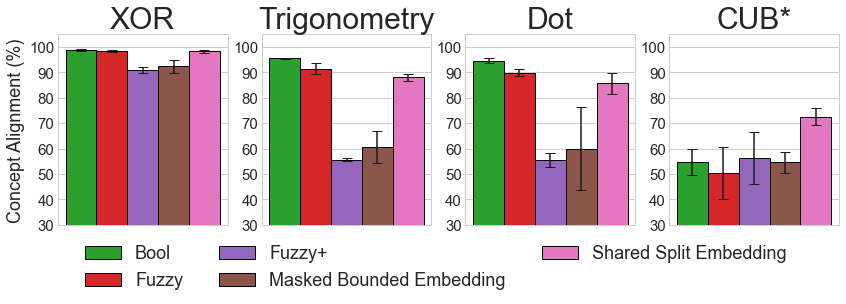

In [258]:
def bold_text(x):
    if LATEX_SYMBOL == "$":
        return r"$\textbf{" + x + "}$"
    return x

clrs = sns.color_palette("tab20", 30)
color_map = {
    'Bool': clrs[4],
    'Fuzzy': clrs[6], 
    'Fuzzy+': clrs[8],
    'Masked Bounded Embedding': clrs[10],
    'Shared Split Embedding': clrs[12],
}
fig_width = 14
fig_height = 3.5
scale = 1
trials = 5
num_models = len(methods)

fig, axs = plt.subplots(1, 4, figsize=(fig_width, fig_height))
for j, (experiment_name, _) in enumerate(experiments.items()):
    ax = axs[j]
    mean = auc_scores.groupby(['experiment', 'method']).mean().reset_index()
    std = auc_scores.groupby(['experiment', 'method']).std().reset_index()
    for i, (_, method_name) in enumerate(methods.items()):
        color = color_map[method_name]
#         print(experiment_name, method_id, method_name, mean[method_name])
        ax.bar(
            i,
            mean[(mean['experiment']==experiment_name) & (mean['method']==method_name)]['concept AUC (%)'],
            width=1,
            color=color,
            align='center',
            label=method_name,
            yerr=std[(std['experiment']==experiment_name) & (std['method']==method_name)]['concept AUC (%)'],
            capsize=5,
            edgecolor="black",
        )
    if j == 0:
        ax.set_ylabel("Concept Alignment (%)", fontsize=18)
    ax.set_title(bold_text(experiment_name), fontsize=30)
    ax.set_xticks([])
    ax.set_yticks(np.arange(30, 105, 10))
    ax.set_yticklabels(list(map(lambda x: f"{x}", np.arange(30, 105, 10))), fontsize=15)
    ax.set_ylim((30, 105))
    ax.grid(axis='y')
    ax.grid(True)

handles, labels = ax.get_legend_handles_labels()

lgd = fig.legend(handles, labels, fontsize=18, loc='upper center', bbox_to_anchor=(0.5,0.11), ncol=(num_models+2)//2)
plt.savefig(
    os.path.join('./results/all_concept_auc.png'),
    bbox_extra_artists=(lgd,),
    bbox_inches='tight'
)
plt.savefig(
    os.path.join('./results/all_concept_auc.pdf'),
    bbox_extra_artists=(lgd,),
    bbox_inches='tight'
)
plt.show()


In [239]:
mean = auc_scores.groupby(['experiment', 'method']).mean().reset_index()#.to_frame()#['concept AUC (%)']
mean

experiment                    method  index  concept AUC (%)  \
0            Dot                      Bool    0.0        94.669396   
1            Dot                     Fuzzy    0.0        89.963377   
2            Dot                    Fuzzy+    0.0        55.359665   
3            Dot  Masked Bounded Embedding    0.0        59.876717   
4            Dot    Shared Split Embedding    0.0        85.783731   
5   Trigonometry                      Bool    0.0        95.524874   
6   Trigonometry                     Fuzzy    0.0        91.467181   
7   Trigonometry                    Fuzzy+    0.0        55.530061   
8   Trigonometry  Masked Bounded Embedding    0.0        60.588570   
9   Trigonometry    Shared Split Embedding    0.0        88.023411   
10           XOR                      Bool    0.0              NaN   
11           XOR                     Fuzzy    0.0              NaN   
12           XOR                    Fuzzy+    0.0              NaN   
13           XOR  Masked Bounded Embedding    0.0              NaN   
14           XOR    Shared Split Embedding    0.0              NaN   

    task AUC (%)  method_id  fold  
0      11.680334        0.0   2.0  
1      34.991290        1.0   2.0  
2      50.182143        2.0   2.0  
3      39.944964        3.0   2.0  
4      49.323047        4.0   2.0  
5      20.276042        0.0   2.0  
6      44.492118        1.0   2.0  
7      80.076834        2.0   2.0  
8      36.778033        3.0   2.0  
9      54.824172        4.0   2.0  
10           NaN        0.0   2.0  
11           NaN        1.0   2.0  
12           NaN        2.0   2.0  
13           NaN        3.0   2.0  
14           NaN        4.0   2.0

In [191]:
mean[(mean['experiment']==experiment_name) & (mean['method']==method_name)]['task AUC (%)']

4    49.393778
Name: task AUC (%), dtype: float64

In [150]:
palette = {
    'Bool': clrs[4],
    'Fuzzy': clrs[6], 
    'Fuzzy+': clrs[8],
    'Masked Bounded Embedding': clrs[10],
    'Shared Split Embedding': clrs[12],
}
sns.color_palette("tab20", 30)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589)]

C:\Users\pietr\AppData\Local\Temp/ipykernel_372/1210730565.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(map(lambda x: f"{x}", np.arange(40, 105, 10))), fontsize=15)


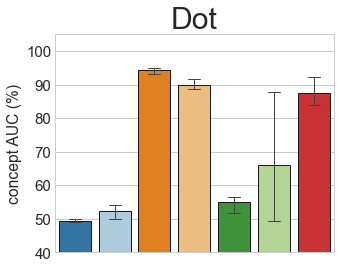

In [87]:
kwargs = {'linewidth': 1, 'edgecolor': 'k'}
plt.figure(figsize=[5, 4])
ax = sns.barplot(data=auc_scores, x='method_id', y='concept AUC (%)', palette=palette, errwidth=1, capsize=0.3, **kwargs)
ax.set_title(bold_text("Dot"), fontsize=30)
# ax.set_xlabel("$\delta$", fontsize=25)
ax.set_xticks([])
ax.set_xticklabels([], fontsize=25)
ax.set_xlabel('')
ax.set_yticklabels(list(map(lambda x: f"{x}", np.arange(40, 105, 10))), fontsize=15)
ax.set_ylim((40, 105))
plt.tight_layout()
plt.show()

In [22]:
# plt.figure(figsize=[15, 5])
# sns.barplot(data=auc_scores, x='method', y='task AUC (%)', palette=palette)
# plt.ylim([0, 1])
# plt.show()

In [46]:
auc_scores

index  concept AUC (%)  task AUC (%)  method_id                    method  \
0       0        49.933418     73.916705          0              VanillaModel   
1       0        49.216825     88.293691          0              VanillaModel   
2       0        49.069858     85.166971          0              VanillaModel   
3       0        54.058975     50.109720          1             VanillaModel+   
4       0        50.019978     79.603936          1             VanillaModel+   
5       0        52.854955     52.107727          1             VanillaModel+   
6       0        95.054846     10.761785          2                      Bool   
7       0        94.795049     12.901549          2                      Bool   
8       0        93.307391     11.338092          2                      Bool   
9       0        91.622919     38.523502          3                     Fuzzy   
10      0        88.648066     35.009546          3                     Fuzzy   
11      0        89.466255     33.699731          3                     Fuzzy   
12      0        56.676761     50.599601          4                    Fuzzy+   
13      0        56.294371     49.812747          4                    Fuzzy+   
14      0        51.839321     50.018282          4                    Fuzzy+   
15      0        49.474549     34.045895          5  Masked Bounded Embedding   
16      0        60.849281     40.497885          5  Masked Bounded Embedding   
17      0        87.789358     49.118108          5  Masked Bounded Embedding   
18      0        92.377280     49.270739          6    Shared Split Embedding   
19      0        83.907225     49.415254          6    Shared Split Embedding   
20      0        85.922449     49.495342          6    Shared Split Embedding   

    fold  
0      0  
1      1  
2      2  
3      0  
4      1  
5      2  
6      0  
7      1  
8      2  
9      0  
10     1  
11     2  
12     0  
13     1  
14     2  
15     0  
16     1  
17     2  
18     0  
19     1  
20     2